In [1]:
import os
import sys
import pandas as pd
import numpy as np
import glob
import time
import gget
import scipy
from scipy.sparse import csr_matrix
import anndata as an
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from importlib import reload
import warnings
import ot

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler

"""WARNING: no warnings"""
warnings.filterwarnings("ignore")

# local imports

import anndata_utils as anntools

source_path = os.path.abspath("../source/")
sys.path.append(source_path)
import centrality as central
import matrix
import utils as ut
import plotting as plt2

In [2]:
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/anndata/population_mESC_1000000_features.h5ad"
# fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/anndata/singlecell_mESC_1000000_features.h5ad"
start_time = time.time()  # Record the start time
adata = sc.read_h5ad(fpath)
end_time = time.time()  # Record the end time
print(f"Time taken to read the file: {end_time - start_time:.2f} seconds")
sc.logging.print_memory_usage()
adata

Time taken to read the file: 141.42 seconds
Memory usage: current 3.04 GB, difference +3.04 GB


AnnData object with n_obs × n_vars = 2579 × 2756467
    obs: 'bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin', 'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'genes', 'n_genes'
    uns: 'base_resolution', 'chrom_sizes', 'gdf', 'gene_map', 'intervals'
    layers: 'H'

In [3]:
adata.var['higher_order'] = adata.var['order'] > 2
adata.var['higher_order'].value_counts(normalize=True)

higher_order
True     0.80905
False    0.19095
Name: proportion, dtype: float64

In [4]:
adata.var['n_chromosomes'].mean()

2.6306605520762627

In [5]:
coverage = adata.X.shape[0] / adata.uns['intervals'].shape[0]
resolution = adata.uns['base_resolution']
print(f"Coverage is {coverage:.3f} of loci at {resolution}Bp resolution")

Coverage is 0.976 of loci at 1000000Bp resolution


In [6]:
# result = []

# bins = [2, 3, 4, 5,  float('inf')]  
# labels = ['2  ', '3  ', '4  ', '5+',]

# for chromosome in adata.uns['chrom_sizes']['chrom']:
#     cdata = anntools.extract_chromosome(adata, chromosome)
#     var = cdata.var.copy()
#     order_binned = pd.cut(var['chrom_order'], bins=bins, labels=labels, right=False)
#     row = order_binned.value_counts(normalize=True).to_dict()
#     row['chrom'] = chromosome
#     result.append(row)

# result = pd.DataFrame(result)
# result = result.set_index('chrom')
# result

In [7]:
# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 12, 5

# sns.heatmap(
#     data=result.T,
#     square=True,
#     annot=True,
#     fmt=".2f",  # Format 
#     cbar_kws={'shrink' : 0.35, 'label' : '% Contacts'},
# )

# plt.xlabel('Chromosome')
# plt.ylabel('Order')
# plt.gca().tick_params(axis='y', rotation=0)

# Extract Single Chromosome

In [8]:
chromosome = "2"
cdata = anntools.extract_chromosome(adata, chromosome)

cdata

View of AnnData object with n_obs × n_vars = 179 × 186499
    obs: 'bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin', 'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6', 'chrom_degree'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'genes', 'n_genes', 'higher_order', 'chrom_order'
    uns: 'base_resolution', 'chrom_sizes', 'gdf', 'gene_map', 'intervals'
    layers: 'H'

# A bit of QC

In [9]:
def find_outliers_iqr(df_column):
  """
  Identifies outliers in a pandas DataFrame column using the IQR method.

  Args:
    df_column: A pandas Series representing the column to analyze.

  Returns:
    A boolean mask with True for outliers and False otherwise.
  """
  Q1 = df_column.quantile(0.15)
  Q3 = df_column.quantile(0.85)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  return (df_column < lower_bound) | (df_column > upper_bound)

cdata.obs['degree_outlier'] = find_outliers_iqr(cdata.obs['chrom_degree'])
cdata.obs[['chrom_bin', 'chrom_degree', 'degree_outlier']].sort_values(by='chrom_degree', ascending=False).head()

,chrom_bin,chrom_degree,degree_outlier
bin_name,,,
chr2:98,98,93161,True
chr2:177,177,3700,True
chr2:174,174,2636,False
chr2:176,176,2293,False
chr2:77,77,2283,False


# Drop the outlier indices

In [10]:
cdata = cdata[~cdata.obs['degree_outlier'], : ].copy()
cdata

AnnData object with n_obs × n_vars = 176 × 186499
    obs: 'bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin', 'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6', 'chrom_degree', 'degree_outlier'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'genes', 'n_genes', 'higher_order', 'chrom_order'
    uns: 'base_resolution', 'chrom_sizes', 'gdf', 'gene_map', 'intervals'
    layers: 'H'

# Plot Degree and Order

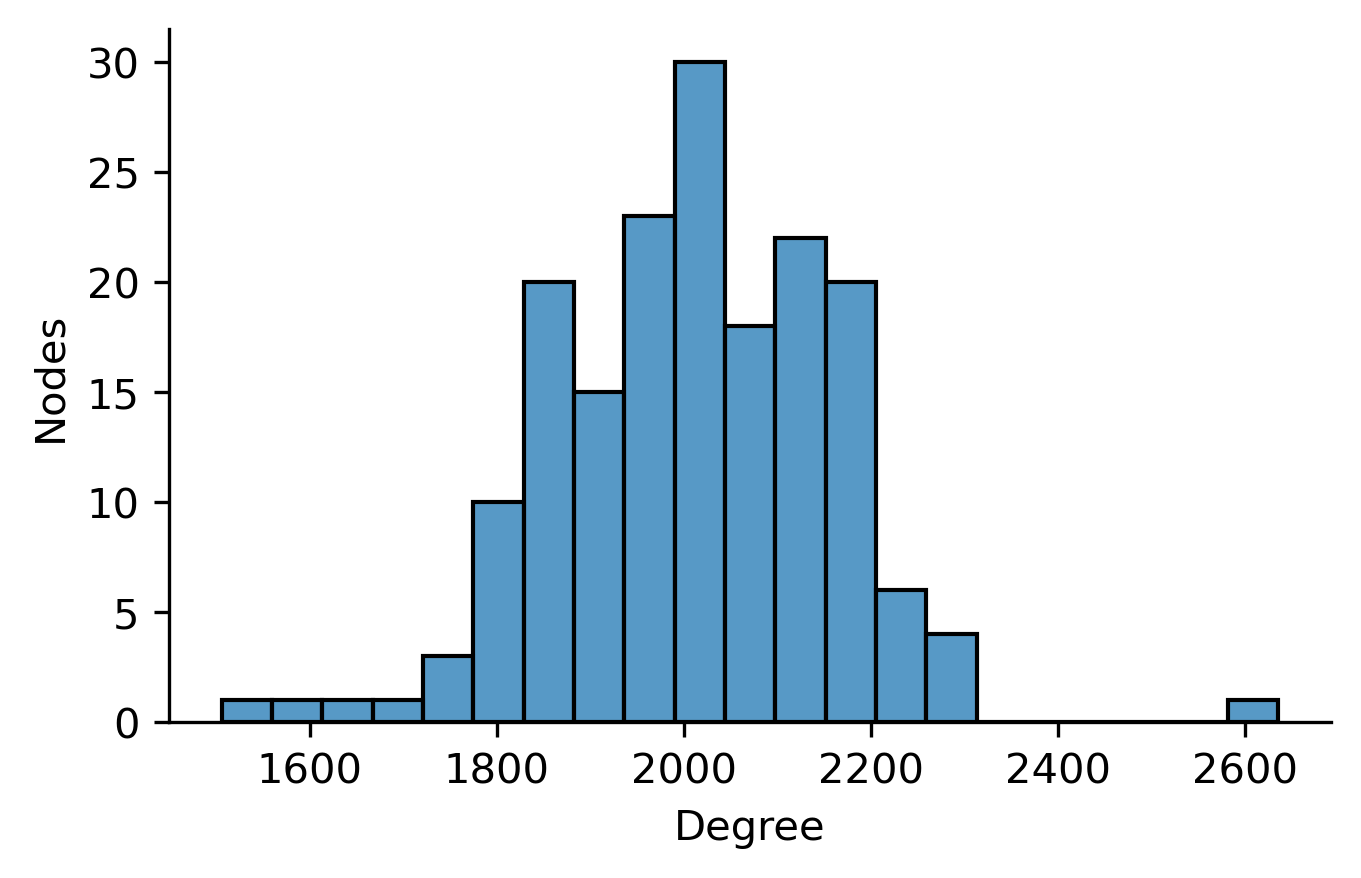

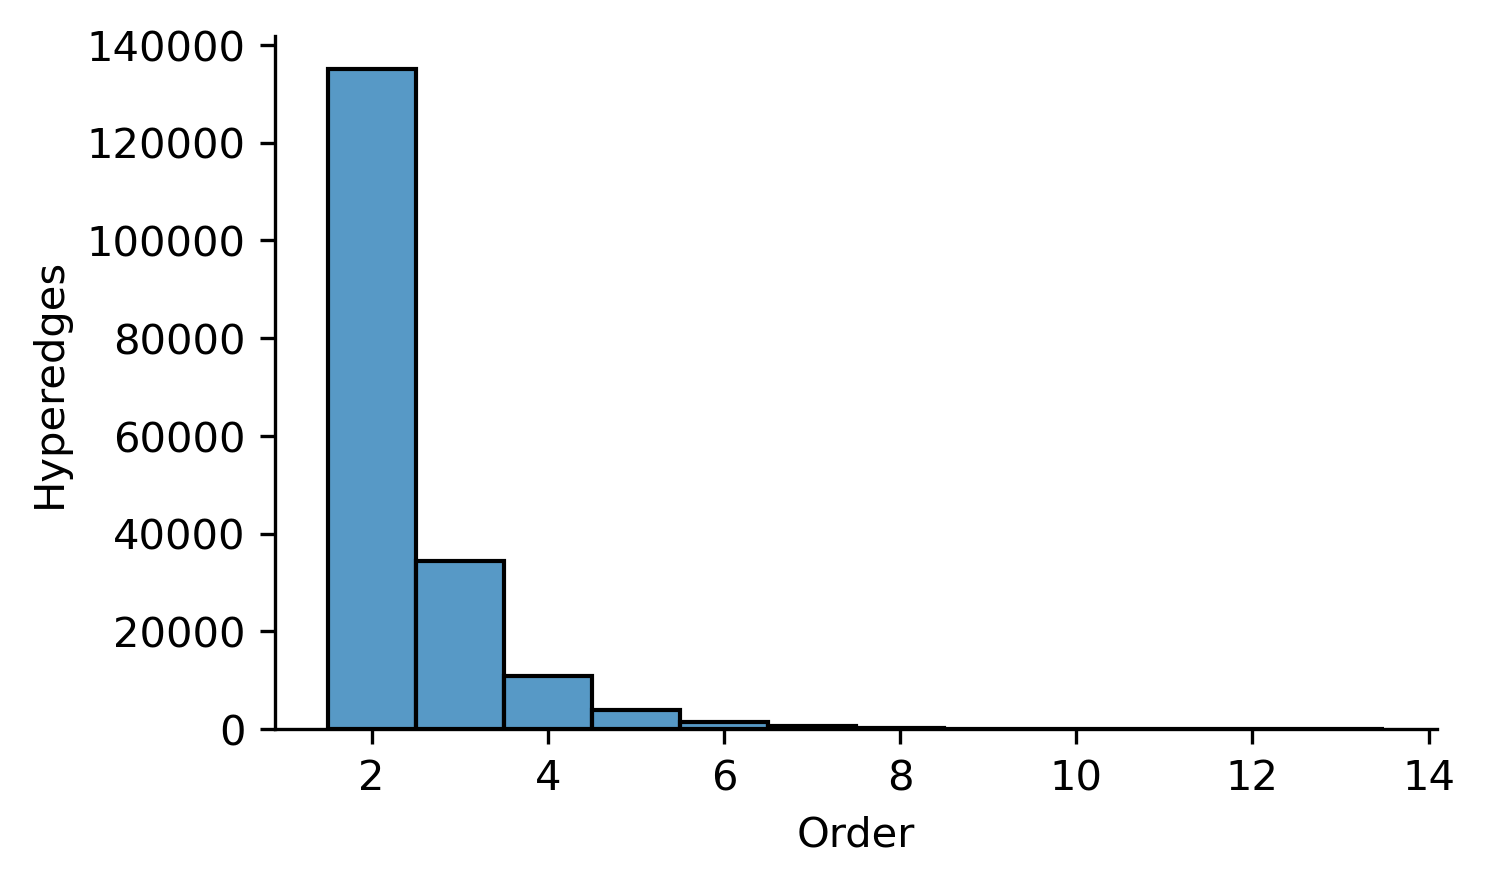

In [11]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 3

sns.histplot(
    data=cdata.obs,
    x='chrom_degree',
    bins=21,
)
plt.xlabel('Degree')
plt.ylabel('Nodes')
sns.despine()
plt.show()

sns.histplot(
    data=cdata.var,
    x='chrom_order',
    discrete=True,
)

plt.xlabel('Order')
plt.ylabel('Hyperedges')
sns.despine()
plt.show()

# Plot incidence matrix

In [12]:
H = cdata.to_df()
H.index = cdata.obs['chrom_bin'].values
H = H.sort_index()
print(f"{H.shape=}")
H.head()

H.shape=(176, 186499)


read_name,3db453c3-be68-417e-bf3f-7d660af7d1aa,2e567d50-8451-4643-a981-1cd91a0062c0,32e53ef8-c394-4db7-bb72-e29a3281a26f,3b0686b6-f18f-495d-89f5-8c8b286c2bb1,ef7ff38e-a5fe-4692-b270-9a704ffa2981,b079fedb-5786-48f4-a0f4-f0e72b85a88f,dc63595a-de81-4976-b052-4f514babc44a,b40b53f2-eb37-4ab7-81c8-ba08d8fd43eb,c7e3608d-c42b-4c51-a1be-c8944d9746a5,b0e7292e-f949-46dc-b91c-7efa75d6f52c,...,0a70ae47-a7fc-43a8-b4f4-48bfa6baf150,0cc4844b-a178-468d-80a1-60bada11b821,45c6a088-2ab4-45c6-856f-12b1a508d94b,50de958b-9a35-4f47-ae81-b248a7edeac5,dc0b7b0b-4a14-49a2-8e48-8416b44f8996,851fee48-7d5e-4de9-9f76-234f2727d0df,ab473b94-fd20-41ed-84d3-e2453b279729,f119b2eb-6b7b-4f13-970d-63d4c83f210d,ceec151d-f1cc-41ed-a0ef-f0636e252160,c26a58f7-0a8c-44e8-bbcc-0bddace54970
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


([], [])

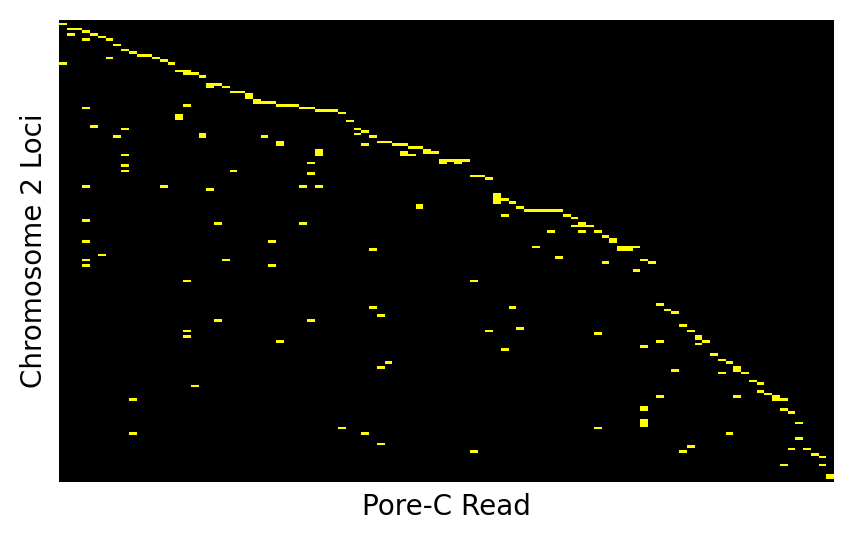

In [13]:
sample_size = 100
pdf = ut.sort_by_lowest_index(H.T.sample(sample_size).T) # sample and sort

# Calculate row and column sums
row_sums = pdf.sum(axis=1)
col_sums = pdf.sum(axis=0)

# Create the heatmap
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 3

sns.heatmap(
    data=pdf,
    cmap='gnuplot',
    cbar=False,
)
plt.ylabel(f"Chromosome {chromosome} Loci")
plt.xlabel(f"Pore-C Read")
plt.xticks([])
plt.yticks([])


Text(0.5, 1.0, 'Chromosome 2')

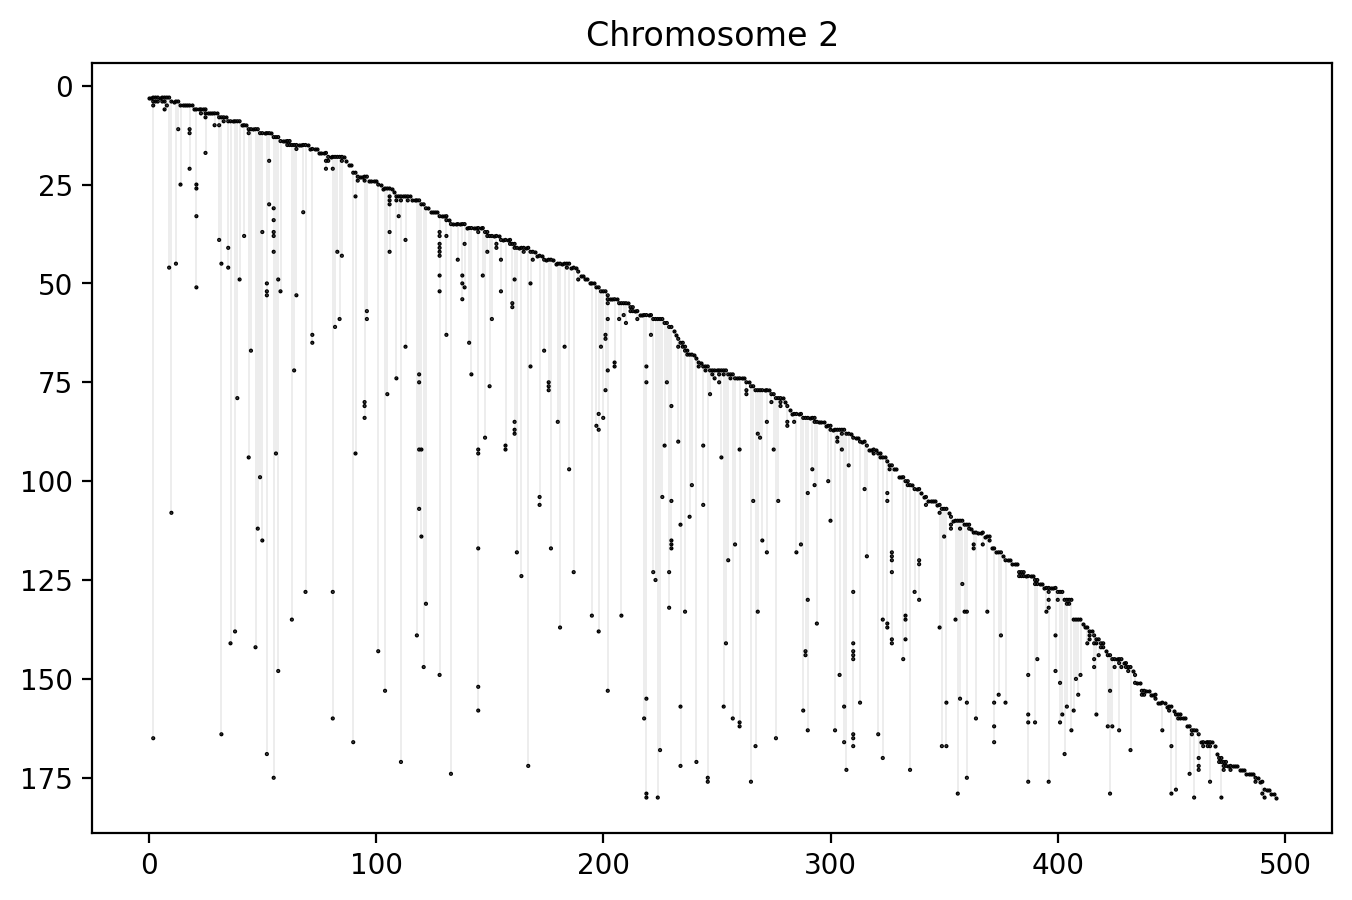

In [14]:
node_params = {
    's' : 1,
    'ec' : 'k',
    'lw' : 1,
    'marker' : ".",
    'zorder' : 2,
}

line_params = {
    'lw' : 0.1,
    'alpha' : 0.5,
    'zorder' : 1,
}

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 5

sample_size = 500
pdf = ut.sort_by_lowest_index(H.T.sample(sample_size).T)

plt2.plot_incidence(
    pdf, 
    node_color='k',
    node_params=node_params,
    line_params=line_params,
)

plt.title(f"Chromosome {chromosome}")

In [15]:
# break

# Clique-Expand the Data

cdata.obsm['A'].shape=(176, 176)
cdata.obsm['A_oe'].shape=(176, 176)


Text(0.5, 51.44444444444443, '')

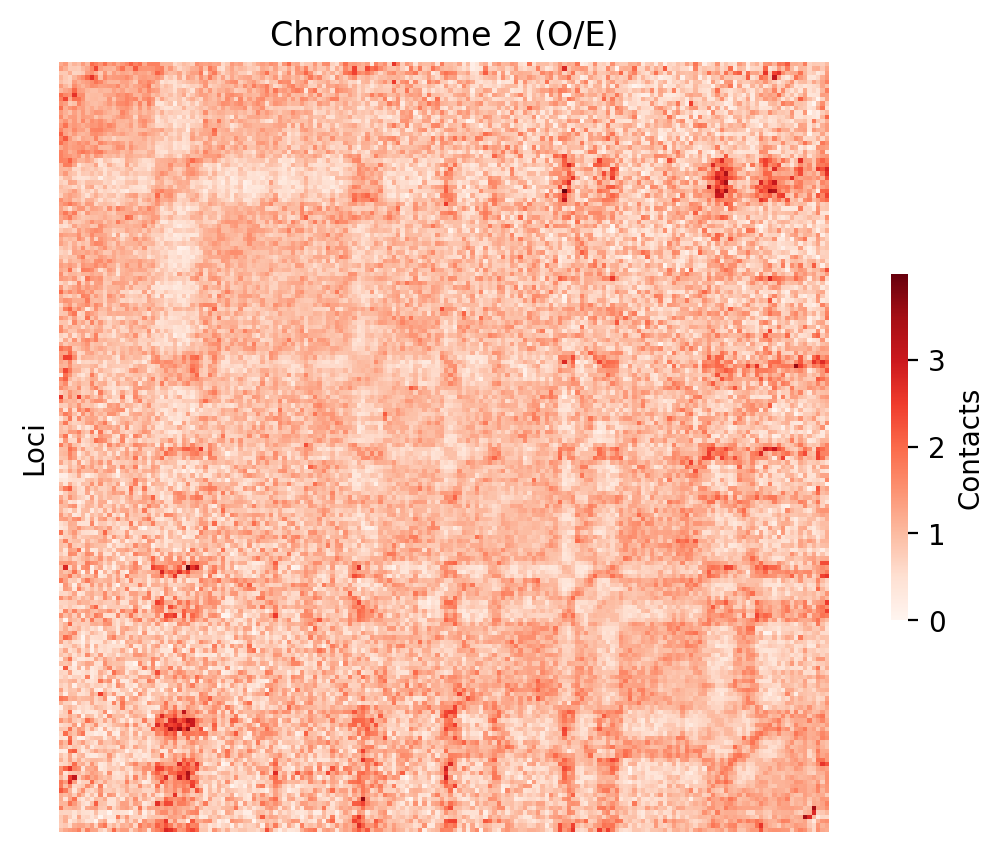

In [16]:
cdata.obsm['A'] = matrix.clique_expand_incidence(cdata.to_df(layer='H'), zero_diag=False) 
print(f"{cdata.obsm['A'].shape=}")

# add the KR normalized expansion
A_kr = matrix.normalize_kr(cdata.obsm['A'].to_numpy())

A_kr = pd.DataFrame(
    A_kr.todense(), 
    index=cdata.obs_names, 
    columns=cdata.obs_names,
)
cdata.obsm['A_kr'] = A_kr

# add the OE normalized matrix
A_oe = matrix.normalize_oe(cdata.obsm['A_kr'].to_numpy())
A_oe = pd.DataFrame(
    A_oe, 
    index=cdata.obs_names, 
    columns=cdata.obs_names,
)
cdata.obsm['A_oe'] = A_oe

print(f"{cdata.obsm['A_oe'].shape=}")

sns.heatmap(
    cdata.obsm['A_oe'],
    square=True,
    cmap='Reds',
    cbar_kws={'shrink' : 0.45, 'label' : 'Contacts'},
)

plt.yticks([])
plt.xticks([])

plt.title(f"Chromosome {chromosome} (O/E)")
plt.ylabel(f"Loci")
plt.xlabel("")

# Network Centralities

In [17]:
ce_centralities = {
    'ce_degree_centrality' : nx.degree_centrality,
    'ce_eigenvector_centrality' : nx.eigenvector_centrality,
    'ce_closeness_centrality' : nx.closeness_centrality,
    'ce_betweenness_centrality' : nx.betweenness_centrality,
}

obsm_key = 'A_oe'
q_threshold = 0.75
print(f"Using obsm key: {obsm_key}")
A = cdata.obsm[obsm_key]

# # binarization
# q = np.quantile(A, q_threshold)
# print(f"Threshold: {q=:.3}")
# A_bin = A.applymap(lambda x: 1 if x > q else 0)

G = nx.from_pandas_adjacency(A)
print(G)

for measure_name, func in ce_centralities.items():
    print(measure_name, func)
    centrality = func(G)
    cdata.obs[measure_name] = cdata.obs.index.map(centrality)

cdata.obs[list(ce_centralities.keys())].head()

Using obsm key: A_oe
Graph with 176 nodes and 15549 edges
ce_degree_centrality <function degree_centrality at 0x14b807ba7b00>
ce_eigenvector_centrality <function eigenvector_centrality at 0x14b807bc4540>
ce_closeness_centrality <function closeness_centrality at 0x14b807ba5800>
ce_betweenness_centrality <function betweenness_centrality at 0x14b807b4bec0>


,ce_degree_centrality,ce_eigenvector_centrality,ce_closeness_centrality,ce_betweenness_centrality
bin_name,,,,
chr2:3,1.011429,0.075508,1.000000,0.00001
chr2:4,1.005714,0.075081,0.994318,0.00001
chr2:5,1.011429,0.075508,1.000000,0.00001
chr2:6,1.011429,0.075508,1.000000,0.00001
chr2:7,1.011429,0.075508,1.000000,0.00001


In [18]:
pdf = cdata.obs.copy()

columns = [
    'n_genes', 
    'ATACSeq_1', 
    'CTCF', 
    'H3K27ac', 
    'H3K27me3',
    'ce_eigenvector_centrality'
]

corr = pdf[columns].corr()
corr

,n_genes,ATACSeq_1,CTCF,H3K27ac,H3K27me3,ce_eigenvector_centrality
n_genes,1.000000,0.282308,0.444731,0.377527,0.052193,0.134369
ATACSeq_1,0.282308,1.000000,0.836030,0.728975,0.332647,0.208888
CTCF,0.444731,0.836030,1.000000,0.877495,0.307813,0.107595
H3K27ac,0.377527,0.728975,0.877495,1.000000,0.045913,0.075916
H3K27me3,0.052193,0.332647,0.307813,0.045913,1.000000,0.132978
ce_eigenvector_centrality,0.134369,0.208888,0.107595,0.075916,0.132978,1.000000


In [19]:
# pdf = cdata.obs.copy()
# pdf = pdf.sort_values(by='chrom_bin')

# for centrality in list(ce_centralities.keys()):
#     print(centrality)
    
#     plt.rcParams['figure.dpi'] = 200
#     plt.rcParams['figure.figsize'] = 10, 2.5

#     y = scipy.stats.zscore(pdf[centrality])
    
#     sns.barplot(
#         data=pdf,
#         x='chrom_bin',
#         y=y,
#         color='deepskyblue',  # Use the calculated colors
#         lw=0.25,
#     )
#     sns.despine()
#     plt.title(centrality)
#     plt.xlabel(f"Chromosome {chromosome} Loci")
#     plt.ylabel(f"Coreness")
#     plt.xticks([])
    
#     plt.show()

# hypergraph normalization

In [20]:
def balance_incidence_matrix(matrix, reg=0.25):
    """Balances a sparse matrix to be doubly stochastic using Sinkhorn-Knopp.

    Args:
        matrix: A scipy.sparse matrix.
        reg: Regularization parameter for Sinkhorn-Knopp algorithm.

    Returns:
        A balanced sparse matrix.
    """
    start_time = time.time()
    matrix = matrix.toarray()  # Convert to dense array for POT
    a = np.ones(matrix.shape[0]) / matrix.shape[0]  # Uniform row distribution
    b = np.ones(matrix.shape[1]) / matrix.shape[1]  # Uniform column distribution
    balanced_matrix = ot.sinkhorn(a, b, matrix, reg)  # Use input regularization parameter
    end_time = time.time()
    print(f"Balancing matrix took: {end_time - start_time:.2f} seconds")
    return csr_matrix(balanced_matrix)  # Convert back to sparse



def add_normalized_layers(cdata, target_sum=1):
    """A function to normalize bins and reads in two ways:
    1. Normalize each observation (row) to sum to target_sum.
    2. Normalize each variable (column) to sum to target_sum.
    """

    # Normalize by observation (rows)
    cdata.layers['obs_norm'] = cdata.X.copy() #create a copy to work on
    sc.pp.normalize_total(
        cdata,
        target_sum=target_sum,
        layer='obs_norm', #operate on the copy
        inplace=True #modify the layer directly
    )

    # Normalize by variable (columns)
    cdata.layers['var_norm'] = cdata.X.copy()
    cdata_T = an.AnnData(cdata.layers['var_norm'].T) #transpose to work on columns
    sc.pp.normalize_total(
        cdata_T,
        target_sum=target_sum,
        inplace=True
    )
    cdata.layers['var_norm'] = cdata_T.X.T #transpose back and assign to the layer

    return cdata
    
start_time = time.time()
cdata = add_normalized_layers(cdata, target_sum=1)
end_time = time.time()
print(f"Normalization took: {end_time - start_time:.2f} seconds")

cdata.layers['H_balanced'] = balance_incidence_matrix(cdata.layers['H'])

# set the layer
default_layer = 'H'
cdata.X = cdata.layers[default_layer].copy()
sc.logging.print_memory_usage()
cdata

Normalization took: 0.11 seconds
Balancing matrix took: 1.59 seconds
Memory usage: current 3.97 GB, difference +0.92 GB


AnnData object with n_obs × n_vars = 176 × 186499
    obs: 'bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin', 'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6', 'chrom_degree', 'degree_outlier', 'ce_degree_centrality', 'ce_eigenvector_centrality', 'ce_closeness_centrality', 'ce_betweenness_centrality'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'genes', 'n_genes', 'higher_order', 'chrom_order'
    uns: 'base_resolution', 'chrom_sizes', 'gdf', 'gene_map', 'intervals'
    obsm: 'A', 'A_kr', 'A_oe'
    layers: 'H', 'obs_norm', 'var_norm', 'H_balanced'

# compute hypergraph centralities

In [21]:
layer_key = "H"

sc.pp.pca(
    cdata, 
    n_comps=1,
    zero_center=False,
    layer=layer_key,
)

# add the principal singular value of the incidence matrix
svd = TruncatedSVD(n_components=1, n_iter=10)
cdata.obs['singular_value_1'] = ut.min_max(svd.fit_transform(cdata.layers[layer_key]))
cdata.obs['PC_1'] = ut.min_max(cdata.obsm['X_pca'][:, 0])

# hypergraph centralities
functions = [
    "linear", "log-exp", "max"
]

hge_centralities = []

for func in functions:
    start_time = time.time()  # Record start time

    node, edge = central.nonlinear_eigenvector_centrality(
        cdata.layers[layer_key],
        function=func,
        maxiter=1000,
    )

    col_name = f"hge_{func}_centrality"
    hge_centralities.append(col_name)
    cdata.obs[col_name] = ut.min_max(node)
    cdata.var[col_name] = ut.min_max(edge)

    end_time = time.time()  # Record end time
    print(f"{func}_centrality calculation took: {end_time - start_time:.2f} seconds")

sc.logging.print_memory_usage()
cdata

linear_centrality calculation took: 2.58 seconds
log-exp_centrality calculation took: 0.51 seconds
max_centrality calculation took: 0.56 seconds
Memory usage: current 4.01 GB, difference +0.04 GB


AnnData object with n_obs × n_vars = 176 × 186499
    obs: 'bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin', 'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6', 'chrom_degree', 'degree_outlier', 'ce_degree_centrality', 'ce_eigenvector_centrality', 'ce_closeness_centrality', 'ce_betweenness_centrality', 'singular_value_1', 'PC_1', 'hge_linear_centrality', 'hge_log-exp_centrality', 'hge_max_centrality'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'genes', 'n_genes', 'higher_order', 'chrom_order', 'hge_linear_centrality', 'hge_log-exp_centrality', 'hge_max_centrality'
    uns: 'base_resolution', 'chrom_sizes', 'gdf', 'gene_map', 'intervals', 'pca'
    obsm: 'A', 'A_kr', 'A_oe', 'X_pca'
    varm: 'PCs'
    layers: 'H', 'obs_norm', 'var_norm', 'H_balanced'

In [22]:
pdf = cdata.obs.copy()
columns = [
    'ce_eigenvector_centrality',
    'singular_value_1',
    'PC_1', 
    'hge_linear_centrality', 
    'hge_log-exp_centrality', 
    'hge_max_centrality',
]
corr = pdf[columns].corr()
corr

,ce_eigenvector_centrality,singular_value_1,PC_1,hge_linear_centrality,hge_log-exp_centrality,hge_max_centrality
ce_eigenvector_centrality,1.000000,0.282618,0.276321,0.283207,-0.055788,0.239845
singular_value_1,0.282618,1.000000,0.990006,0.999865,-0.166543,0.782213
PC_1,0.276321,0.990006,1.000000,0.989942,-0.171989,0.767222
hge_linear_centrality,0.283207,0.999865,0.989942,1.000000,-0.167181,0.782187
hge_log-exp_centrality,-0.055788,-0.166543,-0.171989,-0.167181,1.000000,0.422708
hge_max_centrality,0.239845,0.782213,0.767222,0.782187,0.422708,1.000000


In [23]:
pdf = cdata.obs.copy()

columns = [
    'n_genes', 
    'ATACSeq_1', 
    'CTCF', 
    'H3K27ac', 
    'H3K27me3',
    'hge_linear_centrality',
    'hge_log-exp_centrality',
] 

corr = pdf[columns].corr()
corr

,n_genes,ATACSeq_1,CTCF,H3K27ac,H3K27me3,hge_linear_centrality,hge_log-exp_centrality
n_genes,1.000000,0.282308,0.444731,0.377527,0.052193,-0.057015,0.145104
ATACSeq_1,0.282308,1.000000,0.836030,0.728975,0.332647,0.145610,0.211759
CTCF,0.444731,0.836030,1.000000,0.877495,0.307813,-0.095980,0.320261
H3K27ac,0.377527,0.728975,0.877495,1.000000,0.045913,-0.169758,0.365601
H3K27me3,0.052193,0.332647,0.307813,0.045913,1.000000,0.167932,0.128755
hge_linear_centrality,-0.057015,0.145610,-0.095980,-0.169758,0.167932,1.000000,-0.167181
hge_log-exp_centrality,0.145104,0.211759,0.320261,0.365601,0.128755,-0.167181,1.000000


In [24]:
corr = pdf[list(ce_centralities.keys()) + hge_centralities].corr()
corr

,ce_degree_centrality,ce_eigenvector_centrality,ce_closeness_centrality,ce_betweenness_centrality,hge_linear_centrality,hge_log-exp_centrality,hge_max_centrality
ce_degree_centrality,1.000000,0.999997,0.999995,0.943402,0.283083,-0.055607,0.239745
ce_eigenvector_centrality,0.999997,1.000000,0.999991,0.942525,0.283207,-0.055788,0.239845
ce_closeness_centrality,0.999995,0.999991,1.000000,0.943390,0.283331,-0.055635,0.239814
ce_betweenness_centrality,0.943402,0.942525,0.943390,1.000000,0.251201,-0.029584,0.213393
hge_linear_centrality,0.283083,0.283207,0.283331,0.251201,1.000000,-0.167181,0.782187
hge_log-exp_centrality,-0.055607,-0.055788,-0.055635,-0.029584,-0.167181,1.000000,0.422708
hge_max_centrality,0.239745,0.239845,0.239814,0.213393,0.782187,0.422708,1.000000


# visualize

Wed Dec 18 10:58:05 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Wed Dec 18 10:58:05 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


singular_value_1


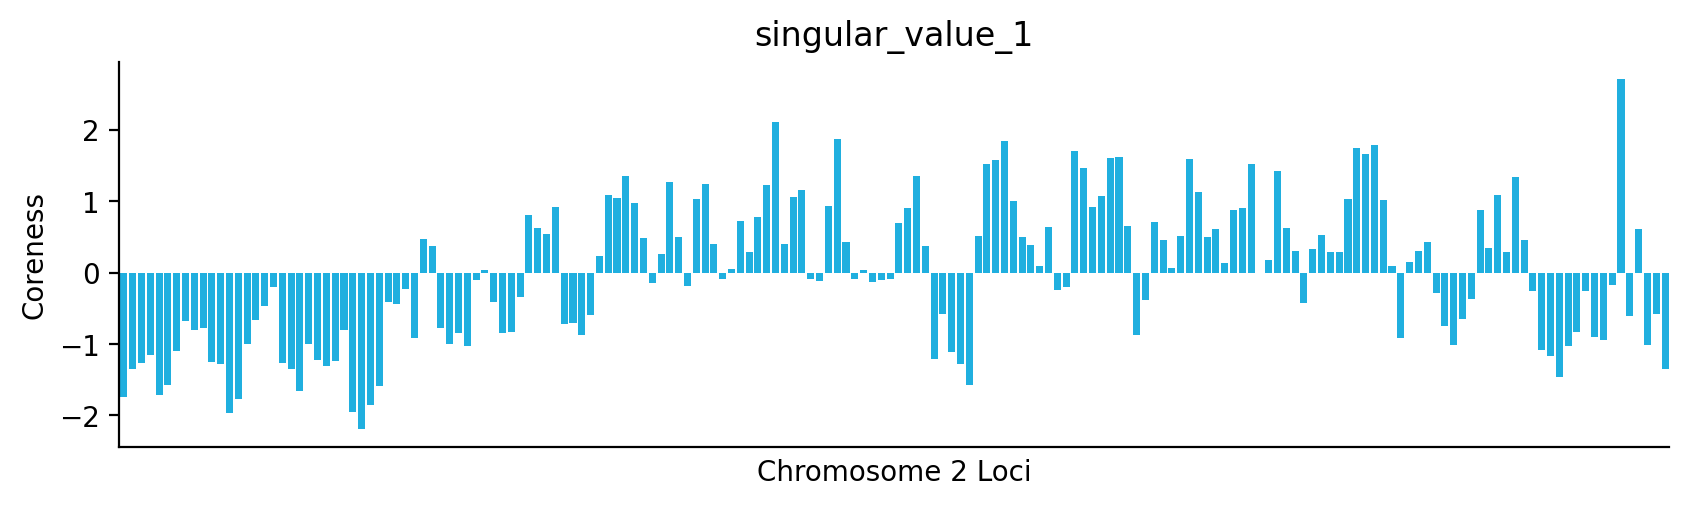

Wed Dec 18 10:58:05 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Wed Dec 18 10:58:05 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


hge_linear_centrality


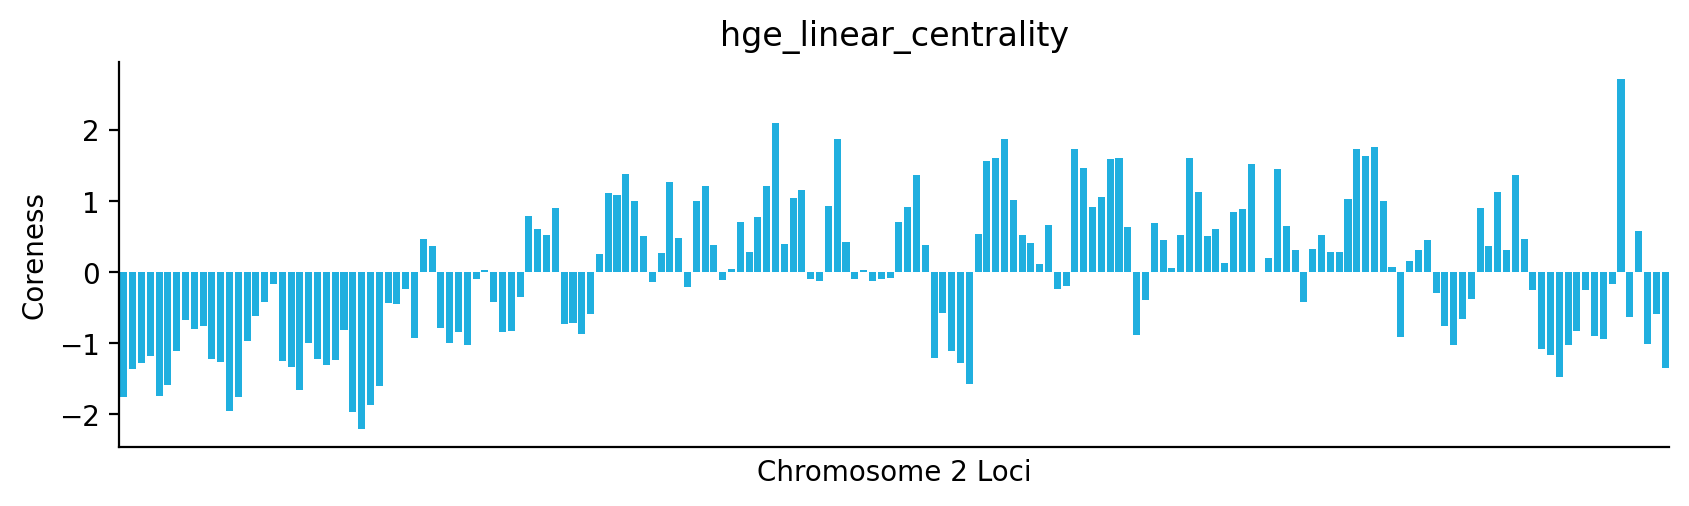

Wed Dec 18 10:58:06 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Wed Dec 18 10:58:06 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


hge_log-exp_centrality


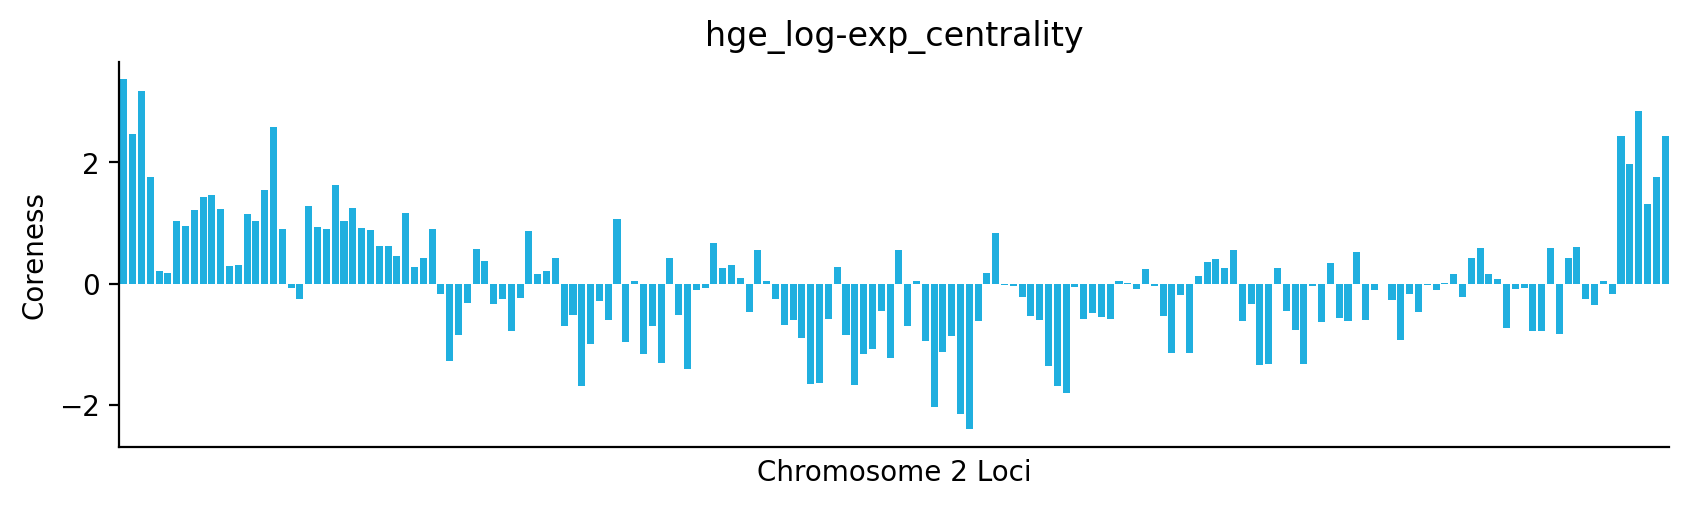

Wed Dec 18 10:58:06 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Wed Dec 18 10:58:06 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


hge_max_centrality


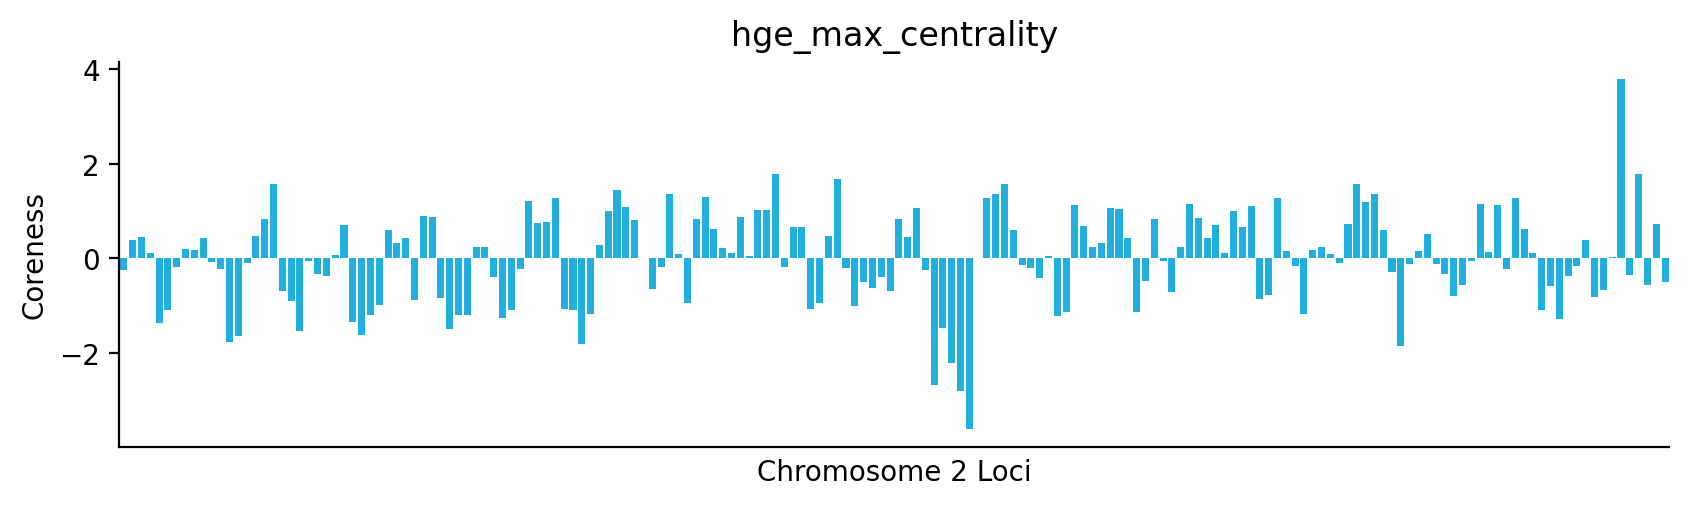

In [25]:
pdf = cdata.obs.copy()
pdf = pdf.sort_values(by='chrom_bin')


for centrality in ['singular_value_1'] + hge_centralities:
    print(centrality)
    
    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 10, 2.5
    
    y = scipy.stats.zscore(pdf[centrality])
    
    sns.barplot(
        data=pdf,
        x='chrom_bin',
        y=y,
        color='deepskyblue',  
        lw=0.25,
    )
    sns.despine()
    plt.title(centrality)
    plt.xlabel(f"Chromosome {chromosome} Loci")
    plt.ylabel(f"Coreness")
    plt.xticks([])
    
    plt.show()

# Who are the most central nodes?

In [26]:
cdata.obs.columns

Index(['bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin',
       'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3',
       'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4',
       'RNA_5', 'RNA_6', 'chrom_degree', 'degree_outlier',
       'ce_degree_centrality', 'ce_eigenvector_centrality',
       'ce_closeness_centrality', 'ce_betweenness_centrality',
       'singular_value_1', 'PC_1', 'hge_linear_centrality',
       'hge_log-exp_centrality', 'hge_max_centrality'],
      dtype='object')

In [27]:
top_n_loci = 5
column = "ce_eigenvector_centrality"
pdf = cdata.obs.copy()
pdf = pdf.sort_values(by=column, ascending=False,)

# get the genes
gdf = cdata.uns['gene_map'].copy()
gdf = gdf[gdf['gene_biotype'] == 'protein_coding']
gdf = gdf[~gdf['gene_name'].str.startswith('Gm')]
gdf = gdf[gdf['bin_name'].isin(pdf.head(top_n_loci).index)]
gdf = gdf.drop_duplicates(subset='gene_name')
print(f"{gdf.shape=}")
gdf.head()

gdf.shape=(29, 4)


,gene_name,gene_biotype,read_name,bin_name
236,Prex1,protein_coding,d4114553-6657-41ba-9e86-5d5e5ae7c9be,chr2:166
467,Znfx1,protein_coding,5a249218-1da6-49a5-9186-c45f82fb14f3,chr2:166
1140,St8sia6,protein_coding,30ed598f-94ef-4b6b-9644-6da593b24ec9,chr2:13
1940,Rsu1,protein_coding,f98ae173-4708-438b-998f-6473fc81b644,chr2:13
2588,Zfp64,protein_coding,1e681cf3-a010-43af-8034-a4b97c7aefb7,chr2:168


In [28]:
centralities = [
    'ce_degree_centrality', 
    'ce_eigenvector_centrality',
    'ce_closeness_centrality',
    'ce_betweenness_centrality',
    'singular_value_1',
    'hge_linear_centrality',
    'hge_log-exp_centrality', 
    'hge_max_centrality',
]
cdata.obs['score'] = ut.min_max(cdata.obs[centralities].mean(axis=1))
cdata.obs[['ATACSeq_1', 'H3K27ac', 'H3K27me3', 'score', 'chrom_degree']].corr()

,ATACSeq_1,H3K27ac,H3K27me3,score,chrom_degree
ATACSeq_1,1.000000,0.728975,0.332647,0.257232,0.322747
H3K27ac,0.728975,1.000000,0.045913,0.021981,0.145613
H3K27me3,0.332647,0.045913,1.000000,0.233855,0.267041
score,0.257232,0.021981,0.233855,1.000000,0.960972
chrom_degree,0.322747,0.145613,0.267041,0.960972,1.000000


In [29]:
top_n_loci = 10
column = "score"
pdf = cdata.obs.copy()
pdf = pdf.sort_values(by=column, ascending=False,)

# get the genes
gdf = cdata.uns['gene_map'].copy()
gdf = gdf[gdf['gene_biotype'] == 'protein_coding']
gdf = gdf[~gdf['gene_name'].str.startswith('Gm')]
gdf = gdf[gdf['bin_name'].isin(pdf.head(top_n_loci).index)]
gdf = gdf.drop_duplicates(subset='gene_name')
print(f"{gdf.shape=}")
gdf.head()

gdf.shape=(97, 4)


,gene_name,gene_biotype,read_name,bin_name
832,Nat10,protein_coding,4df9b62c-5dbc-475f-abd0-abaf5dc9209b,chr2:103
894,Zfp385b,protein_coding,6e1ca717-143a-4ee4-b379-e4c838952f37,chr2:77
1110,Wt1,protein_coding,fc2b56ff-d873-4904-89ca-c3065314c16d,chr2:104
1378,A930018P22Rik,protein_coding,71723aad-5ba9-4de3-b1d7-8715c5c135be,chr2:103
2264,Hipk3,protein_coding,ff025e5d-14bb-414d-995d-3cdd0f11be70,chr2:104


In [30]:
edf = gget.enrichr(gdf['gene_name'].to_list(), database='celltypes')
edf.head()

Wed Dec 18 10:58:12 2024 INFO Performing Enichr analysis using database PanglaoDB_Augmented_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


,rank,path_name,p_val,z_score,combined_score,overlapping_genes,adj_p_val,database
0,1,Erythroblasts,0.003128,7.090681,40.894310,"[LMO2, TUBB1, PRG2, CD44]",0.291845,PanglaoDB_Augmented_2021
1,2,Loop Of Henle Cells,0.005722,5.943304,30.687405,"[CALCRL, APLNR, SERPING1, PAMR1]",0.291845,PanglaoDB_Augmented_2021
2,3,Reticulocytes,0.013788,6.320106,27.074940,"[ZDHHC5, NAT10, SSRP1]",0.351013,PanglaoDB_Augmented_2021
3,4,Satellite Glial Cells,0.018049,5.690627,22.846007,"[APLNR, SLC1A2, SERPING1]",0.351013,PanglaoDB_Augmented_2021
4,5,Airway Goblet Cells,0.019760,5.491582,21.549537,"[EHF, SEC23B, OVOL2]",0.351013,PanglaoDB_Augmented_2021


In [31]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# Plot genes

In [ ]:
pdf = cdata.obs.copy()
pdf = pdf.sort_values(by='chrom_bin')

columns = ['n_genes',]
colors = ['green',]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 3

for i, column in enumerate(columns):

    x = pdf['chrom_bin']
    y = pdf[column]
    
    sns.barplot(
        x=x, y=y,
        color=colors[i],
        lw=0.25,
        label=column,
    )

    plt.xticks([])
    sns.despine()
    
    # # Fill the area under the curve
    # plt.fill_between(
    #     x, y,
    #     color=colors[i],
    #     alpha=0.2,
    # )

In [ ]:
break

In [ ]:
pdf = cdata.obs.copy()
pdf = pdf.sort_values(by='chrom_bin')

for centrality in centralities:
    print(centrality)
    
    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 10, 3

    x = pdf['chrom_bin']
    y = scipy.stats.zscore(pdf[centrality])
    
    sns.lineplot(
        x=x, y=y,
        color='deepskyblue',
        lw=0.25,
    )

    # Fill the area under the curve
    plt.fill_between(
        x, y,
        color='deepskyblue',
        alpha=0.2,
    )

    plt.title(centrality)

    plt.show()

In [ ]:
break

# Clustering

In [ ]:
sc.pp.pca(
    cdata, 
    n_comps=50,
    zero_center=False,
    layer=layer_key,
)

cdata.obs['principal_component_1'] = cdata.obsm['X_pca'][:, 0]
cdata.obs['principal_component_2'] = cdata.obsm['X_pca'][:, 1]

sc.pl.pca_variance_ratio(cdata)
sc.pp.neighbors(cdata)
sc.tl.leiden(cdata, resolution=1)
sc.tl.umap(cdata)

sc.pl.umap(cdata, color=[
    'leiden',
    'bin_start',
    'log_n_genes',
    'log_n_tfs',
    
], ncols=2)

cdata

In [ ]:
sc.pl.umap(cdata, color=[
    'log_n_genes',
    'linear_hg_centrality', 
], ncols=2)

cdata

In [ ]:
cdata.obs[[
    'singular_value_centrality', 
    'linear_hg_centrality', 
    'log-exp_hg_centrality', 
    'max_hg_centrality',
]].corr()

# Plot centralities

In [ ]:
cdata.obs.head()

In [ ]:
pdf = cdata.obs.copy()
pdf = pdf.sort_values(by='chrom_bin')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 3

sns.lineplot(
    data=pdf,
    x='chrom_bin',
    y='n_genes',
    color='grey',
    lw=0.25,
)

# Fill the area under the curve
plt.fill_between(
    pdf['chrom_bin'],
    pdf['n_genes'],
    color='grey',
    alpha=0.2,
)

sns.lineplot(
    data=pdf,
    x='chrom_bin',
    y='n_pt_genes',
    color='green',
    lw=0.25,
)

# Fill the area under the curve
plt.fill_between(
    pdf['chrom_bin'],
    pdf['n_pt_genes'],
    color='green',
    alpha=0.2,
)

sns.lineplot(
    data=pdf,
    x='chrom_bin',
    y='n_tfs',
    color='r',
    lw=0.25,
)

# Fill the area under the curve
plt.fill_between(
    pdf['chrom_bin'],
    pdf['n_tfs'],
    color='r',
    alpha=0.2,
)

# plt.ylim([0, 15])
# plt.xticks([])
# plt.yscale('log')

In [ ]:
break

In [ ]:
cdata.obs.columns

In [ ]:
pdf = cdata.obs.copy()
pdf = pdf.sort_values(by='chrom_bin')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 3

sns.lineplot(
    data=pdf,
    x='chrom_bin',
    y='singular_value_centrality',
    color='C0',
    lw=0.25,
)

# Fill the area under the curve
plt.fill_between(
    pdf['chrom_bin'],
    pdf['singular_value_centrality'],
    color='C0',
    alpha=0.2,
)

# plt.xticks([])
# plt.yscale('log')

In [ ]:
cdata.obs.column

In [ ]:
cdata.uns['genes']['gene_biotype'].value_counts()

In [ ]:
break

# Clique Expansion

In [ ]:
reload(matrix)

adata.obsm['A'] = np.dot(adata.X, adata.X.T)
print(type(adata.obsm['A']))
print(adata.obsm['A'].shape)

adata

In [ ]:
break

In [ ]:
break

# Degree Centrality

In [ ]:
pdf = adata.obs.copy()
pdf['n_reads'] = pdf['n_reads'].astype(int)
sns.histplot(
    data=pdf,
    x='n_reads',
    log_scale=True,
)

In [ ]:
pdf = adata.obs.copy()
pdf = pdf.sort_values(by='bin')
print(f"{pdf.shape=}")

pdf['bin'] = pdf['bin'].astype(int)
pdf['n_reads'] = pdf['n_reads'].astype(int)
pdf['n_reads_log'] = np.log1p(pdf['n_reads'])

plt.rcParams['figure.figsize'] = 10, 5

sns.barplot(
    data=pdf,
    x='bin',
    y='n_reads_log',
    hue='chrom',
    legend=False,
    palette='tab20b',
    ec='none',
    width=0.4,
)

plt.xticks([])
pdf.head()


In [ ]:
pdf.head(15)

In [ ]:
break

In [ ]:
result = []

for chrom, group in adata.obs.groupby('chrom'):
    chrom_data = adata[group.index,]
    chrom_data = chrom_data[:, chrom_data.X.sum(axis=0) > 1]
    
    row = {
        'chrom' : chrom,
        'n_bins' : chrom_data.shape[0],
        'n_reads' : chrom_data.shape[1],
        'mean_order' : chrom_data.var['order'].mean(),
        'median_order' : chrom_data.var['order'].median(),
        'chrom_connectivity' : chrom_data.var['n_chromosomes'].mean(),
    }
    result.append(row)
    # break

result = pd.DataFrame(result)
result.head()

In [ ]:
sns.barplot(
    data=result,
    x='chrom',
    y='mean_order',
)

# highest degree centrality

In [ ]:
def flatten_list(nested_list):
  flat_list = []
  for sublist in nested_list:
    for item in sublist.split(';'):
      flat_list.append(item)
  return flat_list

In [ ]:
n_nodes = 50
df = adata.obs.copy()
df = df.sort_values(by='n_reads', ascending=False)

df = df.head(n_nodes)
genes = flatten_list(df['genes'].values)
print(f"Total Genes: {len(genes)}")
genes = [x for x in genes if not x.startswith('Gm')] # exclude the predicted genes
genes = [x for x in genes if not x.endswith('Rik')] # exclude the Rik genes
genes = [x for x in genes if not "-" in x] # exclude the predicted genes
print(f"Filtered Genes: {len(genes)}")
genes[:10]

In [ ]:
database = 'ontology'
edf = gget.enrichr(genes, database=database)
edf.head(25)

In [ ]:
edf['path_name'].head(25).values

In [ ]:
break

In [ ]:
adata.var.head()

In [ ]:
break

# centrality

In [ ]:
# add the principal singular value of the incidence matrix
svd = TruncatedSVD(n_components=1, n_iter=7)
adata.obs['singular_value_centrality'] = svd.fit_transform(adata.X)
adata

# Hypergraph Centrality

In [ ]:
functions = [
    "linear", "log-exp", "max"
]

for func in functions:
    start_time = time.time()  # Record start time

    node, edge = central.nonlinear_eigenvector_centrality(
        adata.X,
        function=func,
        maxiter=1000,
    )

    col_name = f"{func}_hg_centrality"
    adata.obs[col_name] = node
    adata.var[col_name] = edge

    end_time = time.time()  # Record end time
    print(f"{func}_centrality calculation took: {end_time - start_time:.2f} seconds")

adata

# Clique expansion

In [ ]:
reload(matrix)

adata.obsm['A'] = np.dot(adata.X, adata.X.T)
print(type(adata.obsm['A']))
print(adata.obsm['A'].shape)

adata

# visualize

In [ ]:
chr_idx = adata.obs['chrom'] == '2'
A = adata.obsm['A'][chr_idx, :][:, chr_idx][3:, 3:]
A = np.log1p(A.todense())
plt.imshow(A)

In [ ]:
chr2 = adata[adata.obs['chrom'] == '2', :]

chr2.obsm['A'].shape

In [ ]:
# break

# Graph centralities

In [ ]:
def compute_centrality_measures(adata, obsm_key='ce'):
  """
  Computes and adds various centrality measures to an AnnData object.

  Args:
    adata: An AnnData object.
    G: A NetworkX graph object.
    obsm_key: The obsm string for the matrix to use during graph construction

  Returns:
    The modified AnnData object with added centrality measures.
  """
  print(f"Using obsm key: {obsm_key}")
  A = adata.obsm[obsm_key]
  print(f"{A.shape=} {type(A)}")
  G = nx.from_scipy_sparse_array(A)

  print("\tComputing degree centrality...")
  adata.obs[f'degree_centrality_{obsm_key}'] = nx.degree_centrality(G).values()

  print("\tComputing eigenvector centrality...")
  adata.obs[f'eigenvector_centrality_{obsm_key}'] = nx.eigenvector_centrality(G).values()

  print("\tComputing closeness centrality...")
  adata.obs[f'closeness_centrality_{obsm_key}'] = nx.closeness_centrality(G).values()
  return adata

adata = compute_centrality_measures(adata, obsm_key='A')

adata

In [ ]:
nan_count = np.isnan(adata.obsm['A_oe'].data).sum()
nan_count / adata.obsm['A_oe'].size

# Plot

In [ ]:
centrality_cols = [x for x in adata.obs.columns if 'centrality' in x]
corr = adata.obs[centrality_cols].corr()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 10

sns.heatmap(
    corr, 
    square=True,
    lw=1,
    cmap='coolwarm',
    annot=True,
    cbar_kws={'shrink' : 0.3}
)

# investigate

In [ ]:
df.columns

# Compute global centralities

##### 